# Experimental/mixed approach
In this notebook, we will be testing a network which will use the data from dataset to train itself.

In [ ]:
import torch
from torchvision.models import resnet18, resnet50
import model_utils
import plotter
import data_utils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset, Subset
import importlib
import torchvision.transforms as transforms
import xai

model_utils.fix_random(42)
TRAINING_MODE=False
plotter.set_display_mode(True)

import warnings
warnings.filterwarnings("ignore", category=UserWarning) # fixes PIL not scrollable bug

## Preparing the data

As we're using a mixed approach, we would need to upscale the CIFAKE images to match the size of the other, more complicated ones. Obviously, we will apply all the other transformations needed to the RVAA dataset.

As the CIFAKE dataset is much more oversampled than the RVAA dataset (120'000 vs 1'000 samples) we need to take in consideration a very small subset of CIFAKE in order to create a properly balanced mixed dataset. In particular, we take about 1200 samples from CIFAKE.

In [29]:
IMG_SIZE = 224

transform_cifake = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),  # Convert to RGB
    transforms.Resize((IMG_SIZE, IMG_SIZE)),                # Resize to IMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

d1 = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="train", transform=transform_cifake)
d2 = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="test", transform=transform_cifake)
cifake_dataset = ConcatDataset([d1, d2])

# Selecting a subset of the CIFAKE datasets
portion_size = int(0.0080 * len(cifake_dataset))
indices = list(range(portion_size))
cifake_dataset = Subset(cifake_dataset, indices)

transform_rvaa = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')), # Convert to RGB
    transforms.Resize(IMG_SIZE),                 # Resize to IMG_SIZE while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square), # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),     # Ensure the final image is IMG_SIZExIMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])

rvaa_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform_rvaa)

# the final dataset that's going to be used
merged_dataset = ConcatDataset([cifake_dataset, rvaa_dataset])

In [18]:
LEARNING_RATE = 3e-4
EPOCHS = 20
BATCH_SIZE = 64
DATASET_NAME = "MIXED"

In [ ]:
# WARNING: IF YOU REBUILD THE DATALOADER, THE RESULT WILL DIFFER. RESTART THE KERNEL AND TRAIN AGAIN TO HAVE THE SAME RESULTS.
train_dataset, val_dataset, test_dataset = data_utils.train_test_split((0.7, 0.15), dataset=merged_dataset, isRandom=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

print(len(val_dataset), len(test_dataset), len(train_dataset))

289 290 1351


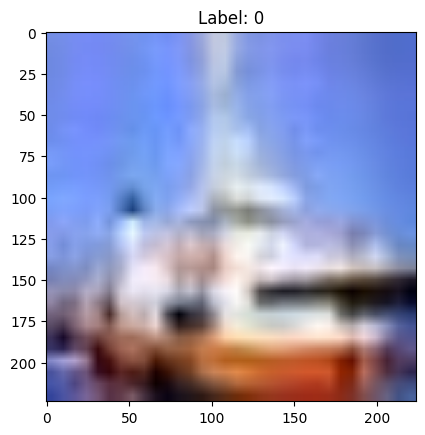

In [ ]:
data_utils.show_random_sample(train_dataloader)

## Model
Since the model that has been giving us great results so far is a ResNet50, we can try and use it again to see if it manages to capture the patterns learned from CIFAKE with the patterns learned from RealVsAiArt.

In [6]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
device = model_utils.get_device()
print(f"using {device} device")

model_utils.prepare_for_ft(ft_resnet50)
ft_resnet50.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)

dataloaders = (train_dataloader, val_dataloader)

using cuda device


## Training setup
The training is done using 20 epochs and a batch size of 64.
As before, we use a 2-step training method which allows us to train the classification head first and then the feature extractor. As shown in the CIFAKE model, this usually deals pretty good results.

In [7]:
model_name = "MixResNet"
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 78.9%, Avg loss: 0.475051
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 78.2%, Avg loss: 0.416069
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 80.3%, Avg loss: 0.388646
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 79.6%, Avg loss: 0.379906
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 80.6%, Avg loss: 0.370938
New best model found! (based on lowest loss)
...and saved.


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 75.8%, Avg loss: 0.388757


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 80.3%, Avg loss: 0.362615
New best model

In [8]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device)

Test Error:
Accuracy: 85.5%, Avg loss: 0.296694
Confusion matrix report, tp: 193, fp: 13, fn: 29, tn:55
Precision: 0.94, Recall: 0.87, F1-Score: 0.90


(0.29669358432292936, tensor(0.8552, device='cuda:0'))

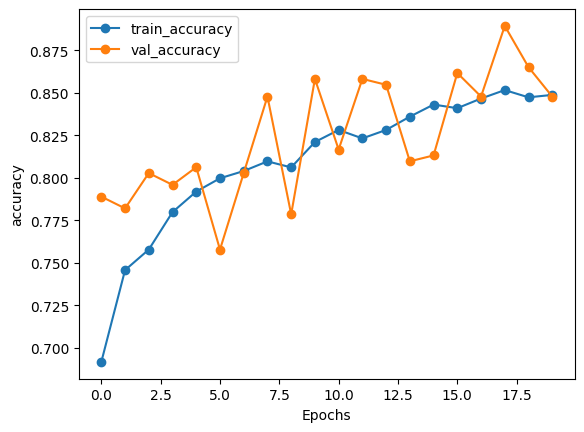

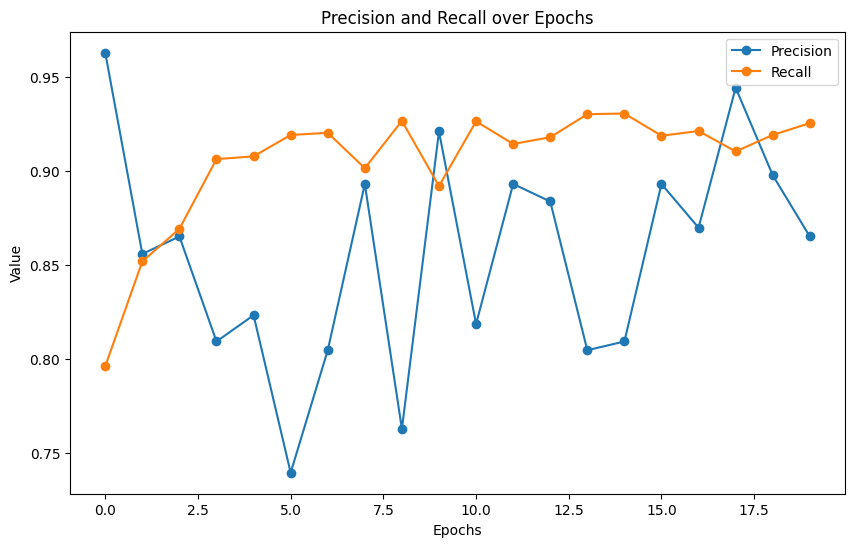

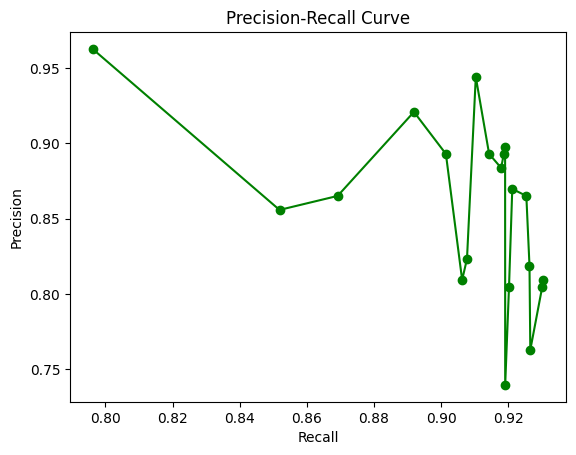

In [9]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

### Fine-tuning step 2
Using a 2-step fine-tuning, we are able to achieve much better performance.

In [10]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)

In [11]:
model_name = "MixResNet_beefy"
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 78.5%, Avg loss: 0.578345
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 84.8%, Avg loss: 0.549241
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 79.2%, Avg loss: 0.677686


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 82.0%, Avg loss: 0.818718


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 86.5%, Avg loss: 0.628211


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 82.0%, Avg loss: 0.851161


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 85.8%, Avg loss: 0.515112
New best model found! (based on lowest loss)
...and saved.


Epoch 8/20
-------------------------------
Validation Error:
Accuracy: 85.8%, Avg loss: 0.494916
New best model found! (based on l

Test Error:
Accuracy: 89.3%, Avg loss: 0.256488
Confusion matrix report, tp: 195, fp: 11, fn: 20, tn:64
True


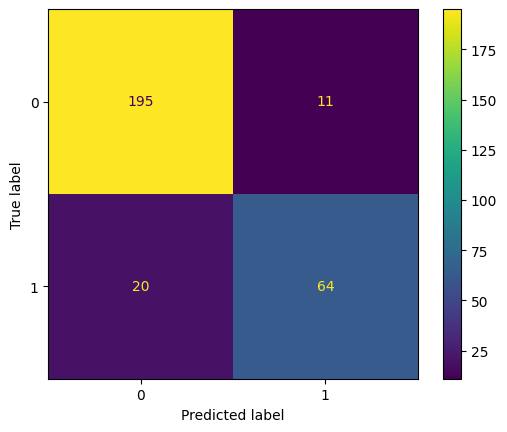

Precision: 0.95, Recall: 0.91, F1-Score: 0.93


(0.25648778975009917, tensor(0.8931, device='cuda:0'))

In [21]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device, model_name=model_name)

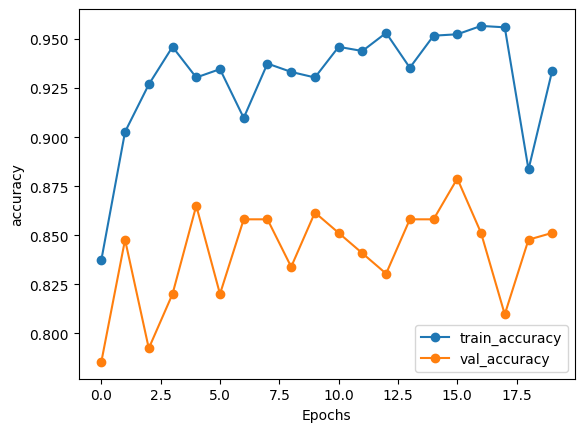

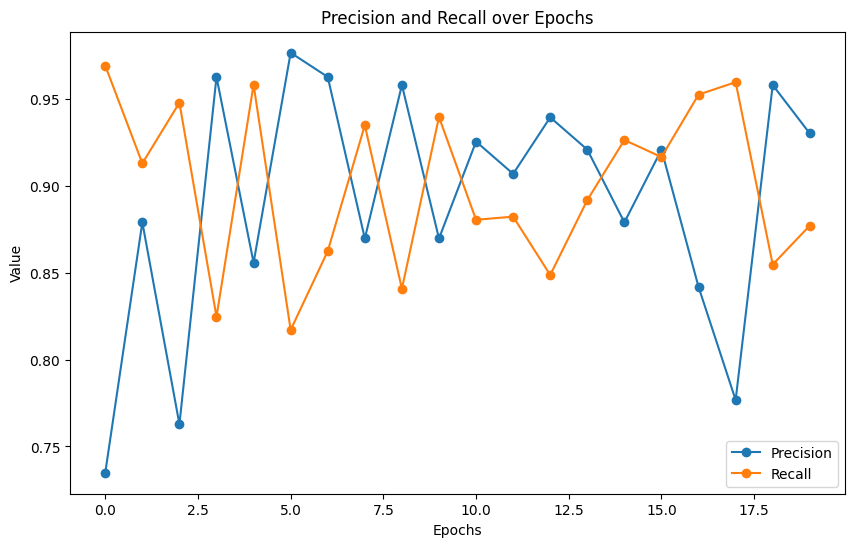

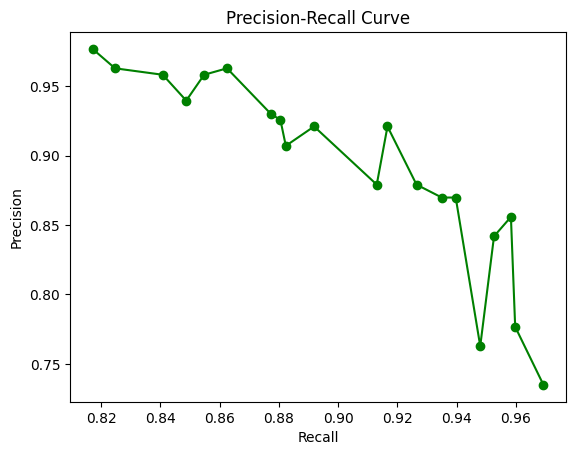

In [13]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts 
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

GradCAM + LIME quick test

In [16]:
target_layers = [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4]

100%|██████████| 64/64 [00:10<00:00,  6.38it/s]


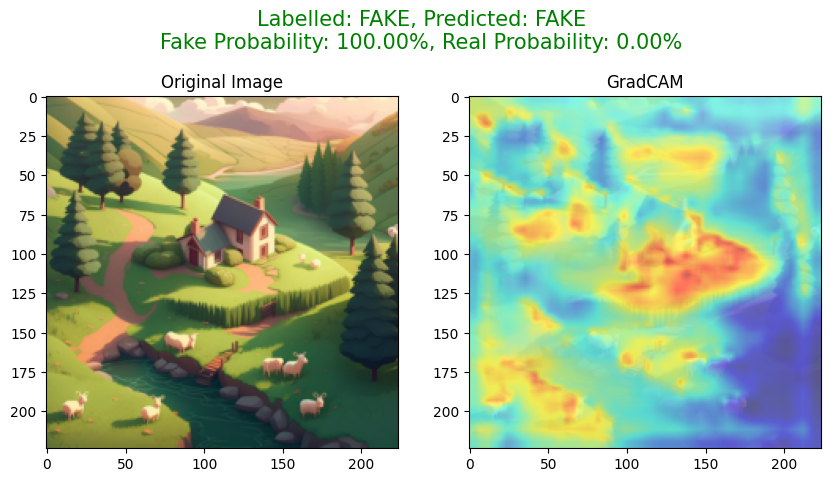

In [ ]:
xai.explain_gradcam_single_image(train_dataloader,
                                ft_resnet50, target_layers, model_name = model_name,
                                dataset_name = DATASET_NAME,
                                index = 3)

  0%|          | 0/1000 [00:00<?, ?it/s]

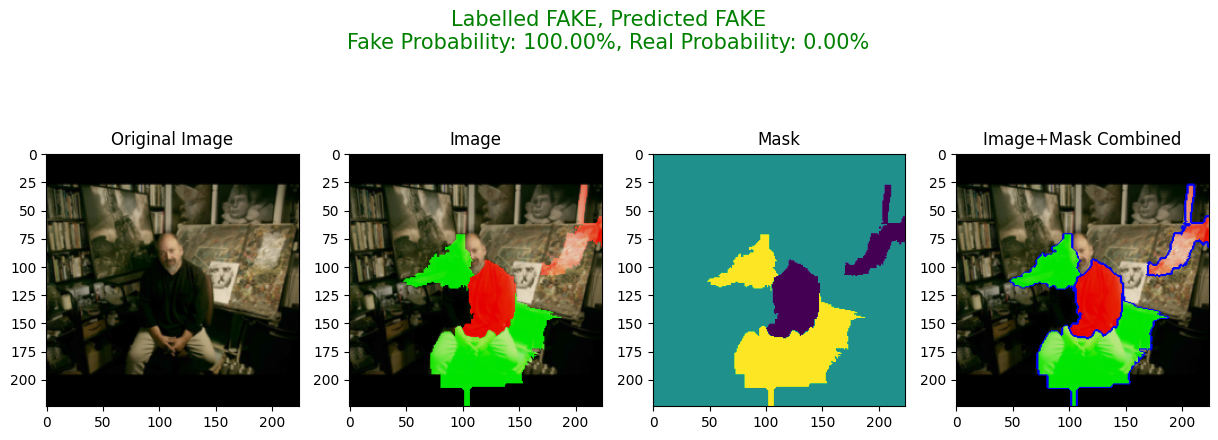

In [15]:
xai.explain_lime_single_image(train_dataloader, ft_resnet50)

### Batch visualization

In [19]:
xai.explain_gradcam_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50, target_layers, model_name, DATASET_NAME)

100%|██████████| 64/64 [00:04<00:00, 15.37it/s]


Visualized batch #1!


In [20]:
xai.explain_lime_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50,
                                model_name=model_name, dataset_name=DATASET_NAME,
                                )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Visualized batch #1!


## Data augmentation
here will be the data augmentation code

In [ ]:
augmented_transform_cifake = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),  # Convert to RGB
    transforms.Resize((IMG_SIZE, IMG_SIZE)),                # Resize to IMG_SIZE
    transforms.RandomResizedCrop(size=(224, 224)),  # Randomly crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.RandomRotation(20),  # Randomly rotate the image by up to 20 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmented_transform_rvaa = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')), # Convert to RGB
    transforms.Resize(IMG_SIZE),                 # Resize to IMG_SIZE while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square), # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),     # Ensure the final image is IMG_SIZExIMG_SIZE
    transforms.RandomResizedCrop(size=(224, 224)),  # Randomly crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.RandomRotation(20),  # Randomly rotate the image by up to 20 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])

In [78]:
# Load CIFAKE dataset and take a small subset
cifake_train = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="train", transform=augmented_transform_cifake)
cifake_test = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="test", transform=transform_cifake)


# Take 0.8% of CIFAKE and split into train, val, and test
portion_size_train = int(0.010 * len(cifake_train)) 
cifake_subset_train = Subset(cifake_train, list(range(portion_size_train)))

cifake_train, cifake_val, _ = data_utils.train_test_split(
    split_ratio=(0.85, 0.15),  # 85% train, 15% val
    dataset=cifake_subset_train,
    isRandom=True
)

portion_size_test = int(0.010 * len(cifake_test))  
cifake_test = Subset(cifake_test, list(range(portion_size_test)))


# Load RVAA dataset with transformations and without
aug_rvaa_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=augmented_transform_rvaa)
rvaa_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform_rvaa)

# DIVIDE BETWEEN AUGMENTED DATA AND NOT AUGMENTED (TRAIN, VAL, TEST)
rvaa_train, _, _ = data_utils.train_test_split(
    split_ratio=(0.7, 0.15),  # 70% train, 15% val, 15% test
    dataset=aug_rvaa_dataset,
    isRandom=True
)

_, rvaa_val, rvaa_test = data_utils.train_test_split(
    split_ratio=(0.7, 0.15),  # 70% train, 15% val, 15% test
    dataset=rvaa_dataset,
    isRandom=True
)

In [79]:
train_dataset = ConcatDataset([cifake_train, rvaa_train])
val_dataset = ConcatDataset([cifake_val, rvaa_val])
test_dataset = ConcatDataset([cifake_test, rvaa_test])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 1529
Validation dataset size: 295
Testing dataset size: 346


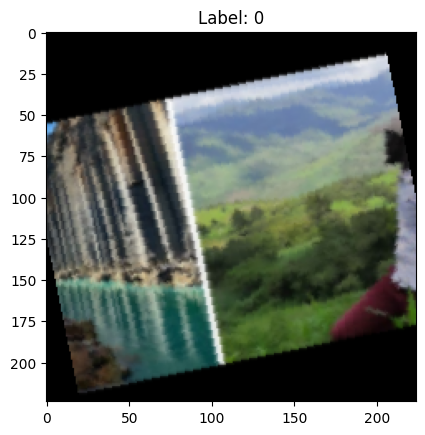

In [59]:
data_utils.show_random_sample(train_dataloader)

In [61]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
device = model_utils.get_device()
print(f"using {device} device")

model_utils.prepare_for_ft(ft_resnet50)
ft_resnet50.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)

dataloaders = (train_dataloader, val_dataloader)

using cuda device


### Training Step1

In [62]:
model_name = "Augmented_MixResNet"
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 74.2%, Avg loss: 0.503450
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 78.3%, Avg loss: 0.439878
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 79.3%, Avg loss: 0.410113
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 79.0%, Avg loss: 0.418289


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 82.7%, Avg loss: 0.375357
New best model found! (based on lowest loss)
...and saved.


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 83.4%, Avg loss: 0.366625
New best model found! (based on lowest loss)
...and saved.


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 84.7%, Avg loss: 0.352773
New best model

Test Error:
Accuracy: 85.8%, Avg loss: 0.337181
Confusion matrix report, tp: 228, fp: 42, fn: 7, tn:69
True


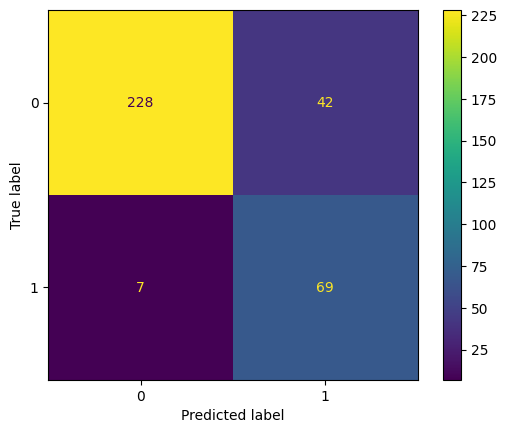

Precision: 0.84, Recall: 0.97, F1-Score: 0.90


(0.3371812229355176, tensor(0.8584, device='cuda:0'))

In [69]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device, model_name=model_name)

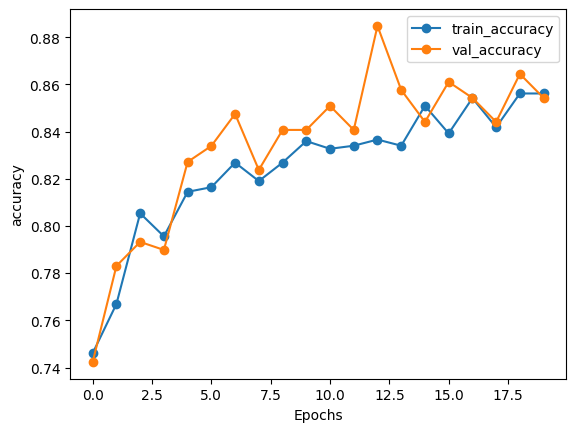

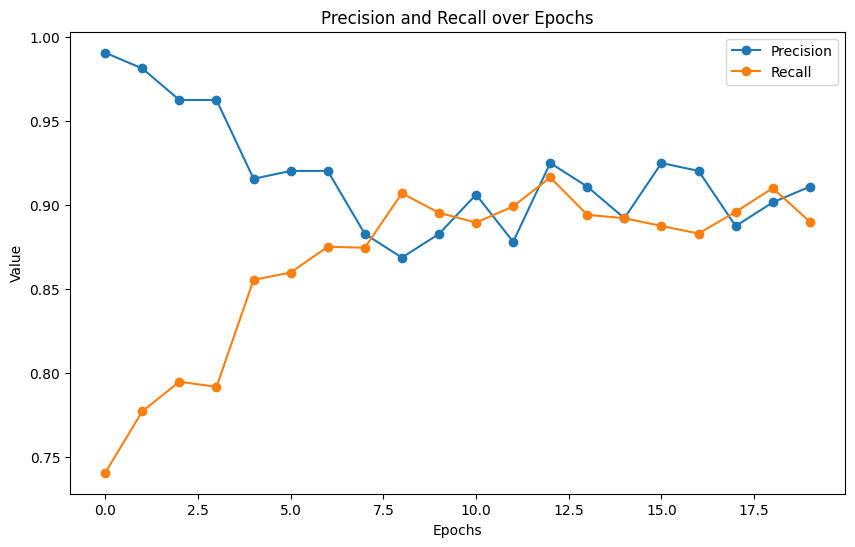

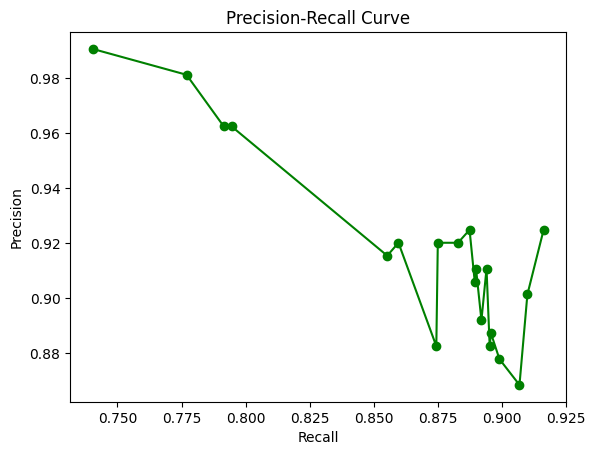

In [64]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

### Training Step2

In [70]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)

In [71]:
model_name = "Augmented_MixResNet_beefy"
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 86.8%, Avg loss: 0.287206
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 89.8%, Avg loss: 0.248572
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 88.1%, Avg loss: 0.220399
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 94.2%, Avg loss: 0.169697
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 83.4%, Avg loss: 0.405443


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 83.4%, Avg loss: 0.416424


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 91.9%, Avg loss: 0.209436


Epoch 8/20
-------------------------------
Validation Error:
Accuracy: 

Test Error:
Accuracy: 96.5%, Avg loss: 0.153987
Confusion matrix report, tp: 261, fp: 9, fn: 3, tn:73
True


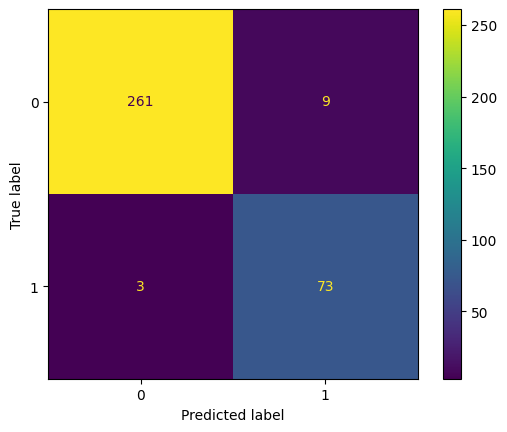

Precision: 0.97, Recall: 0.99, F1-Score: 0.98


(0.15398712185560726, tensor(0.9653, device='cuda:0'))

In [72]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device, model_name=model_name)

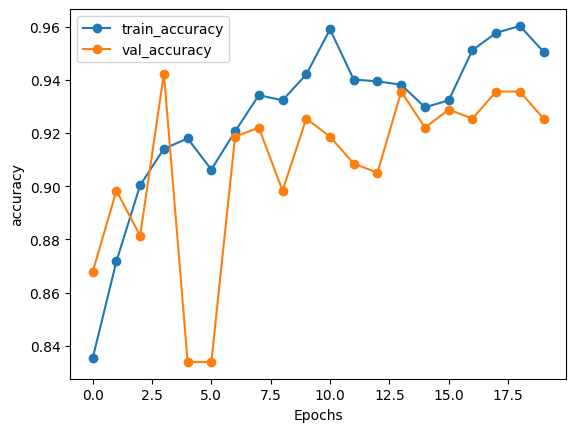

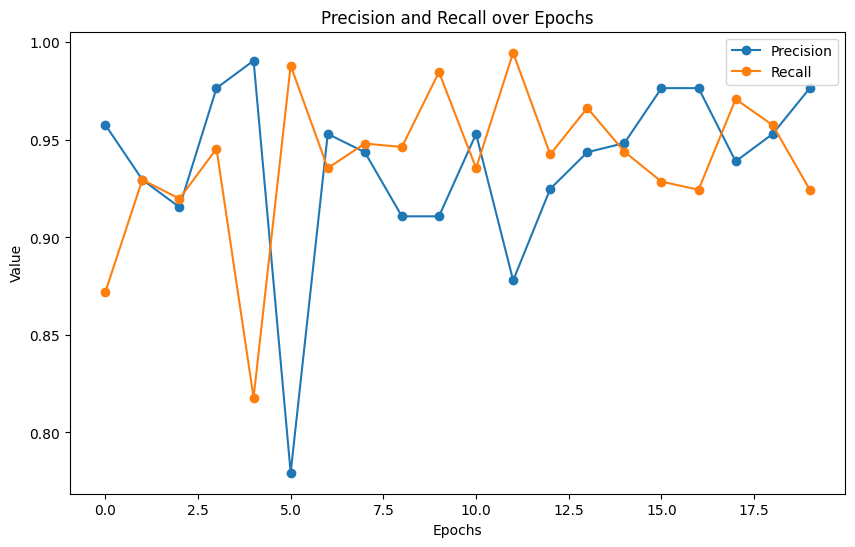

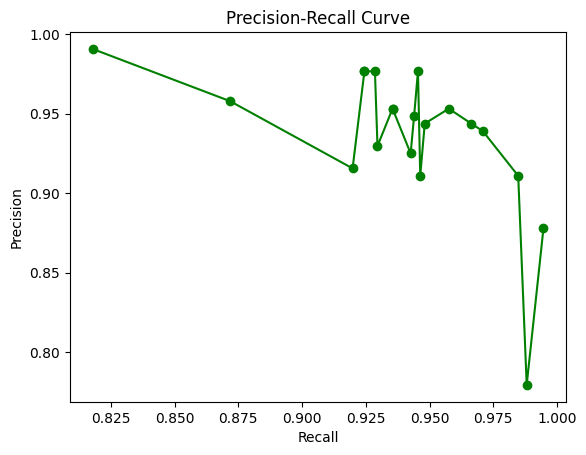

In [73]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts 
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

### GradCam + LIME evaluation

100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


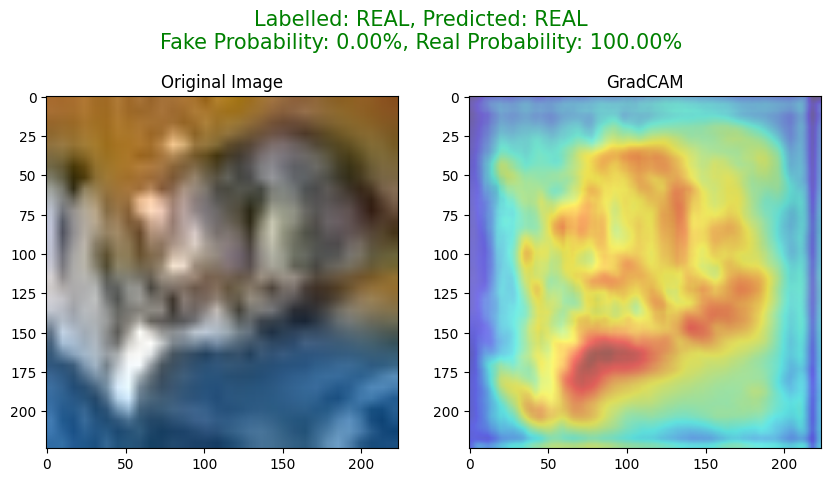

In [85]:
target_layers = [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4]
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, target_layers, model_name = model_name,
                                dataset_name = DATASET_NAME,
                                index = 3)

  0%|          | 0/1000 [00:00<?, ?it/s]

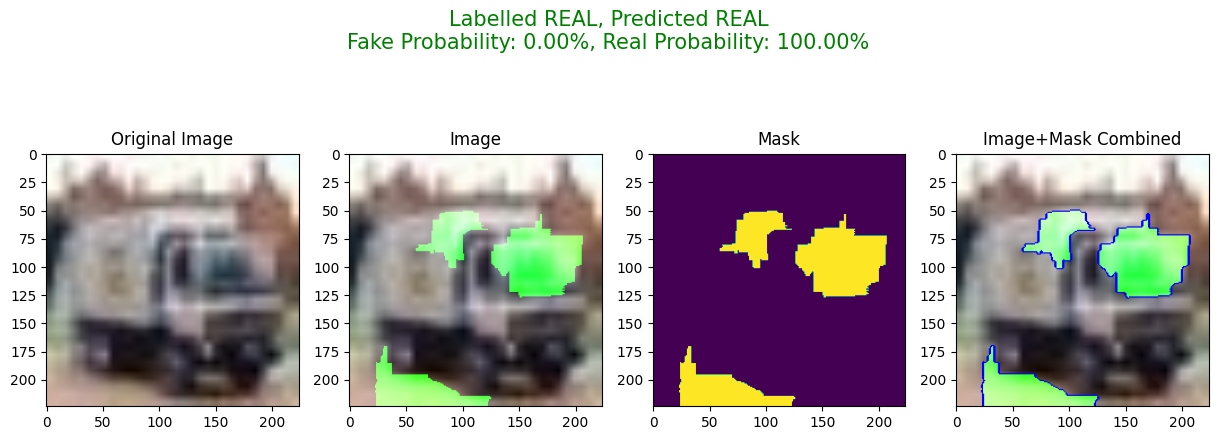

In [83]:
xai.explain_lime_single_image(test_dataloader, ft_resnet50,model_name = model_name,
                                dataset_name = DATASET_NAME)

### Batch visualization

In [ ]:
xai.explain_gradcam_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50, target_layers, model_name, DATASET_NAME)

In [ ]:
xai.explain_lime_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50,
                                model_name=model_name, dataset_name=DATASET_NAME,
                                )